In [4]:
# Get the path to the desktop directory on macOS
import os
user_directory = os.path.join(os.path.expanduser('~'), '')
os.chdir(user_directory)

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import numpy as np
from scipy.linalg import solve_toeplitz, toeplitz
import scipy


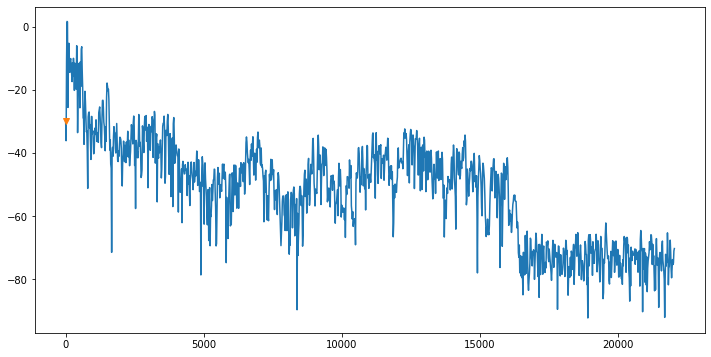

In [22]:

# Load the CSV file into a DataFrame
input_csv_file = './Desktop/Folders/cancer_project/Table_Erfan_[words].csv'  # Replace with your CSV file path
df = pd.read_csv(input_csv_file)

# Load the raw audio file
audio_file = './Desktop/Folders/cancer_project/audio_files/4_Erfan.wav'  # Replace with your audio file path
audio, sample_rate = librosa.load(audio_file, sr=None)

subject = 'Erfan'
output_directory = './Desktop/Folders/cancer_project/Frequency_plots/F_0/' + subject + '/' # Specify the directory where you want to save the plots

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)
counter =0

for index, row in df.iterrows():
    counter = counter+1
    word_name = row['word']
    start_time = row['start']
    end_time = row['end']
    
    # Convert start and end times to sample indices
    start_sample = int(start_time * sample_rate)
    end_sample = int(end_time * sample_rate)

    # Extract the audio segment within the specified time interval
    word_audio = audio[start_sample:end_sample]

    window_length = len(word_audio)

    windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)**2
    frequency_vector = np.linspace(0,sample_rate/2000,int(window_length/2+1))
    signal_spectrum = np.abs(scipy.fft.rfft(word_audio*windowing_function)) #Compute the 1-D discrete Fourier Transform for real input.


    # Find fundamental frequency peak
    ## Derivative is zero at peaks and valleys; similarly, the first difference changes sign.
    ## At peaks, the first difference changes sign from positive negative
    diff_envelope = np.diff(signal_spectrum,axis=0)
    sign_diff_envelope = np.sign(diff_envelope)
    diff_sign_diff_envelope = np.diff(sign_diff_envelope,axis=0)
    peak_indices = np.argwhere(diff_sign_diff_envelope[:] < 0)[:,0]+1
    peak_frequencies = frequency_vector[peak_indices]*1000

    # Suppose F0 is in the range 80 to 450, then the highest peak in that range belongs to the comb structure
    in_range_indices = np.argwhere((peak_frequencies >= 80) & (peak_frequencies <= 450))[:,0]
    if in_range_indices.size > 0:
        largest_index = np.argmax(signal_spectrum[peak_indices[in_range_indices]])
        within_6dB = np.argwhere(signal_spectrum[peak_indices[in_range_indices]] > signal_spectrum[peak_indices[largest_index]]*0.5)
        try:
            F0_index = peak_indices[in_range_indices[within_6dB[0]]]
        except IndexError:
            # Handle the IndexError by appending a zero value
            F0_index = 0
        try:
            plt.figure(figsize=[12,6])

            plt.plot(frequency_vector*1000,20*np.log10(signal_spectrum),label='Spectrum')
            plt.plot(frequency_vector[F0_index]*1000,20*np.log10(signal_spectrum[F0_index]),marker='v',linestyle='',label='Fundamental')
            plt.text(frequency_vector[F0_index]*1000,20*np.log10(signal_spectrum[F0_index]) + 5,'F0='+str(frequency_vector[F0_index[0]]*1000)+'Hz')
            plt.legend()
            plt.title(str(word_name) +' - '+ subject + '  - Log-magnitude spectrum zoomed to [0,2kHz]')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Magnitude $20\log_{10}|X_k|$ (dB)')
            plt.xlim(0,2000)

            plt.tight_layout()

            # Save the figures to the output directory
            figure_filename = os.path.join(output_directory, str(counter)+'_'+f'{word_name}.jpg')
            plt.savefig(figure_filename, dpi=300)
            plt.close()  # Close the figure to release memory
        except TypeError:
            pass


